In [1]:
## LOAD MODULES ##
# Third Party
import sys
import matplotlib.pyplot as plt
import numpy as np
import sys
from pathlib import Path
import psyplot.project as psy
import pandas as pd
import xarray
from netCDF4 import Dataset,date2num
import xarray as xr
from matplotlib import cm
import datetime as dt
from iconarray.plot import formatoptions # import plotting formatoptions (for use with psyplot)
import iconarray as iconvis # import self-written modules from iconarray
import pickle
from matplotlib.lines import Line2D
pd.plotting.deregister_matplotlib_converters()

# First Party
sys.path.append('../utilities_tlezuo/')
# from timefunctions import *
import varfunctions as vf
import locfunctions as lf
import get_stations_timeseries as gs

###############################################################################################
# define class of pc_dict
class Point_coordinates:
    def __init__(self, shortname, name, color, marker, lat, lon, altitude, iconID, iconHSURF, iconHHL, iconHFL, height_dict):
        self.short = shortname
        self.name = name
        self.color = color
        self.marker = marker
        self.lat = lat
        self.lon = lon
        self.alt = altitude
        self.iconID = iconID 
        self.iconHSURF = iconHSURF
        self.iconHHL = iconHHL
        self.iconHFL = iconHFL
        self.hdict = height_dict 


# load pc_dict and its lists
pc_dict = np.load('../utilities_tlezuo/pc_dict.npy',allow_pickle=True).item()

INFO:numexpr.utils:Note: NumExpr detected 36 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [28]:
###############################################################################################
## DECIDE WHAT TO LOAD ##
# location
loc = pc_dict['egg']

# variable lists
spvars_raw_list=[vf.T_2M,vf.VEL_10M,vf.DIR_10M] 
spvars_rad_list=[vf.LW_d,vf.LW_u,vf.SW_d,vf.SW_u] 
spvars_flux_list=[vf.SH_s,vf.LH_s]
spvars_list=[vf.T_2M,vf.VEL_10M,vf.SH_s,vf.LH_s,vf.LWnet_s,vf.SWnet_s,] # to plot

In [29]:
###############################################################################################
## LOAD DATA STATION ##
# variables at station

# from raw
ts_data_stat_raw = gs.read_acinn(loc=loc, 
                    vars=spvars_raw_list,
                    path_ACINN= '/users/tlezuo/data/stations/ACINNiBox',
                    start_time = dt.datetime(2019,9,13,00,00).strftime("%Y-%m-%d %H:%M:%S"),
                    end_time = dt.datetime(2019,9,14,00,00).strftime("%Y-%m-%d %H:%M:%S"),
                    correct_direction=True)
ts_data_stat_raw['dt'] = pd.to_datetime(ts_data_stat_raw["timestamp"])

# from rad
if loc.short in ['arb','hoch','weer']:
    ts_data_stat_rad = gs.read_acinn(loc=loc, 
                        vars=spvars_rad_list,
                        path_ACINN= '/users/tlezuo/data/stations/ACINNiBox',
                        start_time = dt.datetime(2019,9,13,00,00).strftime("%Y-%m-%d %H:%M:%S"),
                        end_time = dt.datetime(2019,9,14,00,00).strftime("%Y-%m-%d %H:%M:%S"),
                        correct_direction=True)
    ts_data_stat_rad['dt'] = pd.to_datetime(ts_data_stat_rad["timestamp"])
    ## CLACULATE NET RAD FLUXES ##
    ts_data_stat_rad['sob_s']=ts_data_stat_rad['sw_down']-ts_data_stat_rad['sw_up']
    ts_data_stat_rad['thb_s']=ts_data_stat_rad['lw_down']-ts_data_stat_rad['lw_up']
else: 
    ts_data_stat_rad=pd.DataFrame()
# from fluxl12

if loc.short in ['hoch','weer','kols','terf','egg']:
    ts_data_stat_flux = gs.read_acinn(loc=loc, 
                        vars=spvars_flux_list,
                        path_ACINN= '/users/tlezuo/data/stations/ACINNiBox',
                        start_time = dt.datetime(2019,9,13,00,00).strftime("%Y-%m-%d %H:%M:%S"),
                        end_time = dt.datetime(2019,9,14,00,00).strftime("%Y-%m-%d %H:%M:%S"),
                        correct_direction=True)
    ts_data_stat_flux['dt'] = pd.to_datetime(ts_data_stat_flux["timestamp"])
    ## REVERSE FLUXES SIGN ##
    ts_data_stat_flux['shfl_s']=-ts_data_stat_flux['shfl_s']
    ts_data_stat_flux['lhfl_s']=-ts_data_stat_flux['lhfl_s']
else: 
    ts_data_stat_flux=pd.DataFrame()


2 files found for this station
found T_2M as tair2 in /users/tlezuo/data/stations/ACINNiBox/acinn_data_i-Box Eggen_FLUX1_e61525fe/data.csv
found VEL_10M as meanu2 in /users/tlezuo/data/stations/ACINNiBox/acinn_data_i-Box Eggen_FLUX1_e61525fe/data.csv
found DIR_10M as wind_dir2 in /users/tlezuo/data/stations/ACINNiBox/acinn_data_i-Box Eggen_FLUX1_e61525fe/data.csv
Index(['columns: T_2M', 'columns: VEL_10M', 'columns: DIR_10M',
       'columns: timestamp'],
      dtype='object')
2 files found for this station
found shfl_s as h2 in /users/tlezuo/data/stations/ACINNiBox/acinn_data_i-Box Eggen_FLUX1_e61525fe/data.csv
found lhfl_s as le2 in /users/tlezuo/data/stations/ACINNiBox/acinn_data_i-Box Eggen_FLUX1_e61525fe/data.csv
Index(['columns: shfl_s', 'columns: lhfl_s', 'columns: timestamp'], dtype='object')


In [30]:
###############################################################################################
## LOAD DATA ICON TS ##
#run2
import glob, os
os.chdir("/store/s83/tlezuo/RUN2_reference/out_hfsu")
ts_data_icon_RUN2 = xarray.open_mfdataset('*0000.nc')
ts_data_icon_RUN2 = ts_data_icon_RUN2.sel(ncells=loc.iconID)
#run3
os.chdir("/store/s83/tlezuo/RUN3_noconv/out_hfsu")
ts_data_icon_RUN3 = xarray.open_mfdataset('*0000.nc')
ts_data_icon_RUN3 = ts_data_icon_RUN3.sel(ncells=loc.iconID)
#run4
os.chdir("/store/s83/tlezuo/RUN4_cosmolev/out_hfsu")
ts_data_icon_RUN4 = xarray.open_mfdataset('*0000.nc')
ts_data_icon_RUN4 = ts_data_icon_RUN4.sel(ncells=loc.iconID)


In [31]:

## CLACULATE VEL AND DIR, SET T[°C] ##
# run2
ts_data_icon_RUN2 = ts_data_icon_RUN2.assign(VEL_10M=vf.calculate_wind_vel_from_uv(ts_data_icon_RUN2['u_10m'],ts_data_icon_RUN2['v_10m']))
ts_data_icon_RUN2 = ts_data_icon_RUN2.assign(DIR_10M=vf.calculate_wind_dir_from_uv(ts_data_icon_RUN2['u_10m'],ts_data_icon_RUN2['v_10m']))
ts_data_icon_RUN2['T_2M'] = ts_data_icon_RUN2['T_2M']-273.15
# run3
ts_data_icon_RUN3 = ts_data_icon_RUN3.assign(VEL_10M=vf.calculate_wind_vel_from_uv(ts_data_icon_RUN3['u_10m'],ts_data_icon_RUN3['v_10m']))
ts_data_icon_RUN3 = ts_data_icon_RUN3.assign(DIR_10M=vf.calculate_wind_dir_from_uv(ts_data_icon_RUN3['u_10m'],ts_data_icon_RUN3['v_10m']))
ts_data_icon_RUN3['T_2M'] = ts_data_icon_RUN3['T_2M']-273.15
# run4
ts_data_icon_RUN4 = ts_data_icon_RUN4.assign(VEL_10M=vf.calculate_wind_vel_from_uv(ts_data_icon_RUN4['u_10m'],ts_data_icon_RUN4['v_10m']))
ts_data_icon_RUN4 = ts_data_icon_RUN4.assign(DIR_10M=vf.calculate_wind_dir_from_uv(ts_data_icon_RUN4['u_10m'],ts_data_icon_RUN4['v_10m']))
ts_data_icon_RUN4['T_2M'] = ts_data_icon_RUN4['T_2M']-273.15

[Text(18152.0, 0, '00'),
 Text(18152.083333333332, 0, '02'),
 Text(18152.166666666668, 0, '04'),
 Text(18152.25, 0, '06'),
 Text(18152.333333333332, 0, '08'),
 Text(18152.416666666668, 0, '10'),
 Text(18152.5, 0, '12'),
 Text(18152.583333333332, 0, '14'),
 Text(18152.666666666668, 0, '16'),
 Text(18152.75, 0, '18'),
 Text(18152.833333333332, 0, '20'),
 Text(18152.916666666668, 0, '22'),
 Text(18153.0, 0, '00')]

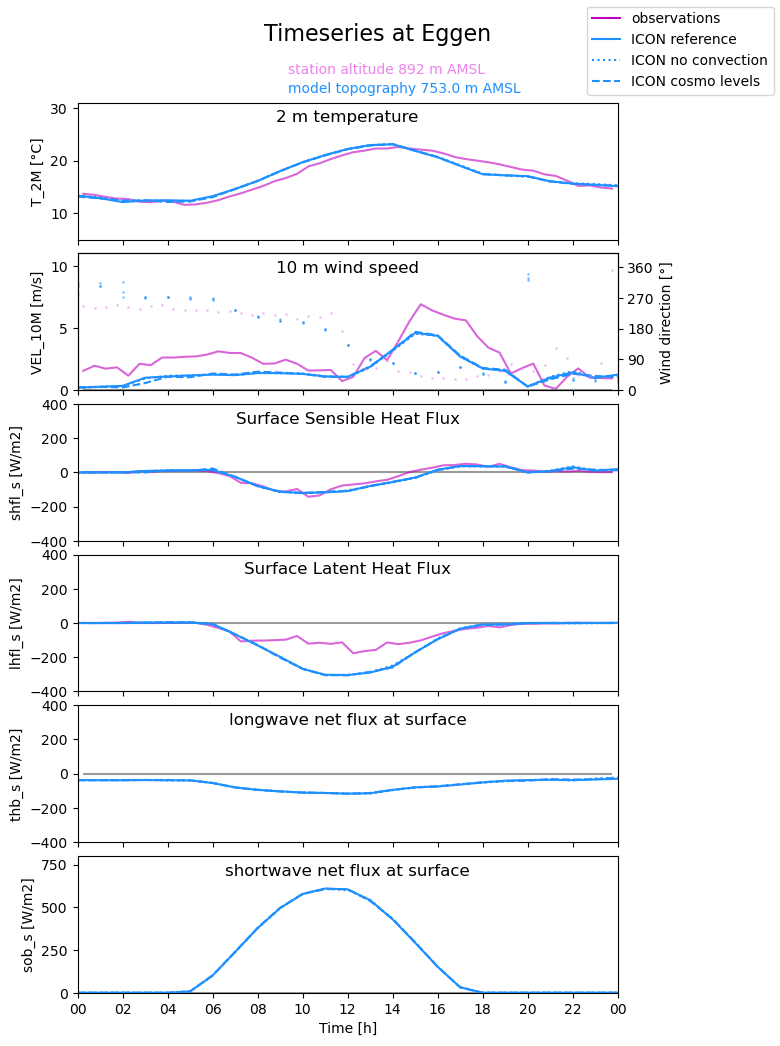

In [32]:

# time range
startdate_plot = dt.datetime(2019,9,13,00,00)
enddate_plot = dt.datetime(2019,9,14,00,00)
plotfreq_plot = '2h0min'
plotdates_plot = pd.date_range(startdate_plot,enddate_plot,freq=plotfreq_plot)

# figure settings
fig, ax = plt.subplots(len(spvars_list),1, figsize=(8,10))
plt.subplots_adjust(bottom=0.01, right=0.8, top=0.9,hspace=0.1)
fig.suptitle('Timeseries at '+loc.name, fontsize=16)
ax[0].annotate('station altitude '+str(loc.alt)+' m AMSL', xy=(0.42,1.17),xytext=(0.39,1.21),xycoords=('axes fraction','axes fraction'),color='violet')
ax[0].annotate('model topography '+str(loc.iconHSURF.round())+' m AMSL', xy=(0.42,0.82),xytext=(0.39,1.07),xycoords=('axes fraction','axes fraction'),color='dodgerblue')
for ax_ts,spvar in zip(ax.flatten(),spvars_list):
        # OBS
        handle_obs = Line2D([0], [0], color='m',linestyle='solid')
        if spvar.name in ts_data_stat_raw.columns:
                ax_ts.plot(ts_data_stat_raw['dt'],np.transpose(ts_data_stat_raw[spvar.name]),color='m',alpha=0.6, label='observations')
        elif spvar.name in ts_data_stat_rad.columns:
                ax_ts.plot(ts_data_stat_rad['dt'],np.transpose(ts_data_stat_rad[spvar.name]),color='m',alpha=0.6, label='observations')
        elif spvar.name in ts_data_stat_flux.columns:
                ax_ts.plot(ts_data_stat_flux['dt'],np.transpose(ts_data_stat_flux[spvar.name]),color='m',alpha=0.6, label='observations')
        # ICON 
        # ax_ts.plot(plotdates_model,ts_data_icon[spvar.name],color='dodgerblue',label='ICON')
        plotdates_model = pd.date_range(startdate_plot,enddate_plot,freq='1h')
        # plotdates_model = ts_data_icon_RUN2.time
        handle_I2 = Line2D([0], [0], color='dodgerblue',linestyle='solid')
        handle_I3 = Line2D([0], [0], color='dodgerblue',linestyle='dotted')
        handle_I4 = Line2D([0], [0], color='dodgerblue',linestyle='dashed')
        # ax_ts.plot(ts_data_icon_RUN1.time,ts_data_icon_RUN1.TKE,color='gray',label='ICON old')
        ax_ts.plot(ts_data_icon_RUN2.time,ts_data_icon_RUN2[spvar.name],color='dodgerblue',label='ICON reference')
        ax_ts.plot(ts_data_icon_RUN3.time,ts_data_icon_RUN3[spvar.name],color='dodgerblue',linestyle = 'dotted', label='ICON no convection')
        ax_ts.plot(ts_data_icon_RUN4.time,ts_data_icon_RUN4[spvar.name],color='dodgerblue',linestyle = 'dashed',label='ICON cosmo levels')

        # plotting options
        ax_ts.set_ylim(spvar.min,spvar.max)
        ax_ts.set_xlim(startdate_plot,enddate_plot)
        # ax_ts.grid()
        ax_ts.set_title(spvar.title, y=1.0, pad=-14)
        ax_ts.set_xlabel('Time [h]')
        ax_ts.set_xticks(plotdates_plot)
        ax_ts.set_xticklabels([])
        ax_ts.set_ylabel(spvar.name+' '+spvar.units)
        ax_ts.hlines(y=0, xmin=ts_data_stat_raw['dt'][0],xmax=ts_data_stat_raw['dt'][-1],colors='k',alpha=0.4)
        # ax_ts.annotate('(obs at '+str(loc.hdict[spvar.name])+' m AGL)', xy=(0.40,0.92),xytext=(0.39,0.92),xycoords=('axes fraction','axes fraction'),color='violet')

        ##################################################################################################
        # ## DIR if VEL is plotted ##
        if spvar.name == 'VEL_10M':
                # plot
                ax_ts_2 = ax_ts.twinx()
                # obs
                ax_ts_2.scatter(ts_data_stat_raw['dt'],np.transpose(ts_data_stat_raw['DIR_10M']),color='violet',alpha=0.4,s=1) # station obs
                # model
                ax_ts_2.scatter(ts_data_icon_RUN2.time,ts_data_icon_RUN2['DIR_10M'],color='dodgerblue',alpha=0.4,s=1)
                ax_ts_2.scatter(ts_data_icon_RUN3.time,ts_data_icon_RUN3['DIR_10M'],color='dodgerblue',alpha=0.4,s=1)
                ax_ts_2.scatter(ts_data_icon_RUN4.time,ts_data_icon_RUN4['DIR_10M'],color='dodgerblue',alpha=0.4,s=1)

                # plotting options
                ax_ts_2.set_ylim(0,400)
                ax_ts_2.set_yticks(np.arange(0,365,90))
                ax_ts_2.set_ylabel('Wind direction [°]')
                ax_ts_2.set_xlim(startdate_plot,enddate_plot)
                ax_ts_2.set_xticks(plotdates_plot)
                ax_ts_2.set_xticklabels([])

legend_handles=[handle_obs,handle_I2,handle_I3, handle_I4]
legend_labels=['observations','ICON reference','ICON no convection','ICON cosmo levels']
fig.legend(legend_handles,legend_labels)
ax[-1].set_xticklabels(labels=[j.strftime('%H') for j in plotdates_plot])